In [1]:
import os
import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import pickle
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import scipy.ndimage.morphology as morph
from scipy.ndimage.filters import median_filter
import scipy.ndimage
from skimage.measure import regionprops
import pandas as pd

import bat_train.evaluate as evl

In [2]:
from helper_fns import *

In [22]:
test_set      = 'uk'  # can be one of: bulgaria, uk, norfolk
data_set      = 'bat_train/data/train_test_split/test_set_' + test_set + '.npz'
raw_audio_dir = 'bat_train/data/wav/'
base_line_dir = 'bat_train/data/baselines/'
result_dir    = 'bat_train/results/'
model_dir     = 'bat_train/data/models/'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
print('test set:', test_set)
plt.close('all')

test set: uk


In [23]:
# train and test_pos are in units of seconds
loaded_data_tr  = np.load(data_set, allow_pickle = True, encoding = 'latin1')
train_pos       = loaded_data_tr['train_pos']
train_files     = loaded_data_tr['train_files']
train_durations = loaded_data_tr['train_durations']
test_pos        = loaded_data_tr['test_pos']
test_files      = loaded_data_tr['test_files']
test_durations  = loaded_data_tr['test_durations']

In [24]:
classes = ['not_bat', 'bat']

In [25]:
train_files_decode = [s.decode() for s in train_files]
test_files_decode  = [s.decode() for s in test_files]

In [26]:
positions, class_labels = generate_training_positions(train_files_decode, train_pos, train_durations)

In [27]:
test_positions, test_class_labels = generate_training_positions(test_files_decode, test_pos, test_durations)

In [28]:
train_paths_decode = [raw_audio_dir + fn for fn in train_files_decode]
test_paths_decode  = [raw_audio_dir + fn for fn in test_files_decode]

In [29]:
sampling_rate, audio_samples = wavfile.read(train_paths_decode[0] + '.wav')

In [30]:
from bat_train.data_set_params import DataSetParams

In [31]:
params = DataSetParams()

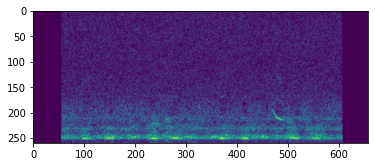

In [32]:
plt.imshow(gen_spectrogram(audio_samples, sampling_rate, params.fft_win_length, params.fft_overlap,
                crop_spec=params.crop_spec, max_freq=params.max_freq, min_freq=params.min_freq))

In [33]:
def spec_post(spec):
    spec = spec[1:, :]
    spec = np.flipud(spec)
    # only keep the relevant bands - could do this outside
    if params.crop_spec:
        spec = spec[-params.max_freq:-params.min_freq, :]
    
        # add some zeros if too small
        req_height = params.max_freq-params.min_freq
        if spec.shape[0] < req_height:
            zero_pad = np.zeros((req_height-spec.shape[0], spec.shape[1]))
            spec     = np.vstack((zero_pad, spec))

    # perform log scaling - here the same as matplotlib
    log_scaling = 2.0 * (1.0 / sampling_rate) * (1.0/(np.abs(np.hanning(int(params.fft_win_length*sampling_rate)))**2).sum())
    spec        = np.log(1.0 + log_scaling*spec)
    return(spec)

In [34]:
from scipy.io import wavfile

In [35]:
count = 0
ndiv = len(train_paths_decode) // 10
for ilab, ipos, idur, file_name in zip(class_labels, positions, train_durations, train_paths_decode):
    #print(ilab, ipos, idur, file_name)
    #print(file_name)
    samp_rate, tmp_audio = wavfile.read(file_name + '.wav')
    if count % ndiv == 0:
        print(count+1, '/', len(train_paths_decode))
    count = count + 1
    if ipos.shape[0] > 0:
        for iipos, iilab  in zip(ipos, ilab):
            startSample   = int( iipos * samp_rate )
            endSample     = int( (iipos+0.230) * samp_rate )
            start_string  = '_'+iipos.round(3).astype('str').replace('.','_')
            new_file_name = file_name.replace('/wav/', '/wav_clips/'+test_set+'/'+classes[int(iilab)]+'/')
            #print(new_file_name)
            wavfile.write(new_file_name+start_string+'.wav', samp_rate, tmp_audio[startSample:endSample])

1 / 2812
282 / 2812
563 / 2812
844 / 2812
1125 / 2812
1406 / 2812
1687 / 2812
1968 / 2812
2249 / 2812
2530 / 2812
2811 / 2812


In [36]:
count = 0
ndiv = len(test_paths_decode) // 10
for ilab, ipos, idur, file_name in zip(test_class_labels, test_positions, test_durations, test_paths_decode):
    #print(ilab, ipos, idur, file_name)
    samp_rate, tmp_audio = wavfile.read(file_name + '.wav')
    if count % ndiv == 0:
        print(count+1, '/', len(test_paths_decode))
    count = count + 1
    if ipos.shape[0] > 0:
        for iipos, iilab  in zip(ipos, ilab):
            startSample   = int( iipos * samp_rate )
            endSample     = int( (iipos+0.230) * samp_rate )
            start_string  = '_'+iipos.round(3).astype('str').replace('.','_')
            new_file_name = file_name.replace('/wav/', '/wav_clips/'+test_set+'/'+classes[int(iilab)]+'/')
            wavfile.write(new_file_name+start_string+'.wav', samp_rate, tmp_audio[startSample:endSample])

1 / 434
44 / 434
87 / 434
130 / 434
173 / 434
216 / 434
259 / 434
302 / 434
345 / 434
388 / 434
431 / 434


In [37]:
neg_time_files = [bf for bf in train_paths_decode if '-' in bf]
neg_time_files.extend([bf for bf in test_paths_decode if '-' in bf])
for neg_file in neg_time_files:
    os.remove(neg_file)